In [1]:
import os
from scipy.spatial import distance
import numpy as np
from scipy.cluster.vq import kmeans

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import simple_gensim

from time import time
from sklearn.metrics import homogeneity_completeness_v_measure

In [21]:
root_dir = "models/relations/"

In [3]:
buckets = np.load('{}/buckets.npy'.format(root_dir))[None][0]
buckets = {
    rel: len(buckets[rel])
    for rel in buckets
}

In [4]:
composit_simple = np.load('{}/composit2simple.npy'.format(root_dir))
composit_simple = composit_simple.T
simple_classes_set = list(set(composit_simple[:,1]))
simple_classes = {
    composit: simple_classes_set.index(simple)
    for composit,simple in composit_simple
}

simple2composit = {
    rel: [composit for composit,simple in composit_simple if rel == simple]
    for rel in simple_classes_set
}

composit2simple = {
    composit: simple
    for composit,simple in composit_simple
}

# the order in following list matters for coloring the results
simple_classes_set2 = [w for w in [
    #'next', 'side', 'beside', 'near',
    'by','with',
    'left', 'right',
#    'before', 'after',
    'behind',
    'back', 'front',
    'below', 'under', 
    'over', 'above',
    'to', 'at', 
#    'away', 'apart',
    'without',
#    'off',
#    'against',
#    'from',
#    'together', 'among',
#    'alongside', 
#    'along', 'across','during', 
#    'sideways', 
    'between', 'within', 'through', 
#    'around', 'about',
#   'inside', 'into', 
#    'onto', 
    'underneath', 'beneath',
#    'out',
    'outside',
    'in',
    'on',
#    'up', 'top', 'down', 'bottom',
#    'upward', 'toward', 'backward', 
#    'here', 'there',
] if w in buckets and buckets[w] >20 ]

non_relations = []
word_filter = [
    w 
    for simple in simple_classes_set2
    for w in simple2composit[simple]
    if w not in non_relations
    if w in buckets and buckets[w] > 50
]


In [29]:
embeddings_lm = np.load('{}/embeddings_lm.npy'.format(root_dir))[None][0]
spatial_lexicon = np.load('{}/spatial_lexicon.npy'.format(root_dir))

In [5]:
embeddings = np.load('{}/embeddings.npy'.format(root_dir))[None][0]
words_contexts = np.load('{}/words_contexts.npy'.format(root_dir))

#contexts_filter = sorted([w for w in buckets if len(buckets[w])>100])
#words_filter = sorted([w for w in buckets if len(buckets[w])>100])

words = np.array(list(words_contexts[0]))
contexts = np.array(list(words_contexts[1]))

embedding_dimensions = [np.where(contexts == w)[0][0] for w in word_filter if w in contexts]
embedding_indices = [np.where(words == w)[0][0] for w in word_filter if w in words]
words = words[embedding_indices]
contexts = contexts[embedding_dimensions]

embeddings = embeddings[embedding_indices][:,embedding_dimensions]
# lower bound norm
embeddings_normal = embeddings/np.expand_dims(np.sum(embeddings, 0),0)
# unit vector norm for clustering
embeddings_normal2 = embeddings_normal / np.expand_dims(np.linalg.norm(embeddings_normal, axis=1),1)

In [8]:
data = embeddings_normal
k = 12
centroids = kmeans(data,k_or_guess=k, iter=1000)
centroids_reps = np.tile(np.expand_dims(centroids[0], 0), (data.shape[0], 1, 1))
embeddings_normal_reps = np.tile(np.expand_dims(data, 1), (1, centroids[0].shape[0], 1))
clusters = np.argmin(np.sum((centroids_reps-embeddings_normal_reps)**2, 2),1)
print(centroids[1])
for i in range(k):
    print('k =', i)
    print([(w, len(w.split())) for w in words[clusters == i]])

0.0146733507523
k = 0
[('over', 1), ('above', 1)]
k = 1
[('left', 1), ('right', 1)]
k = 2
[('to', 1)]
k = 3
[('outside', 1)]
k = 4
[('by', 1), ('behind', 1), ('front', 1), ('in', 1), ('on', 1)]
k = 5
[('back', 1)]
k = 6
[('through', 1)]
k = 7
[('between', 1)]
k = 8
[('with', 1), ('under', 1)]
k = 9
[('at', 1)]
k = 10
[('below', 1)]
k = 11
[('underneath', 1), ('beneath', 1)]


In [34]:
data = embeddings_lm
k = 15
centroids = kmeans(data,k_or_guess=k, iter=1000)
centroids_reps = np.tile(np.expand_dims(centroids[0], 0), (data.shape[0], 1, 1))
embeddings_normal_reps = np.tile(np.expand_dims(data, 1), (1, centroids[0].shape[0], 1))
clusters_lm = np.argmin(np.sum((centroids_reps-embeddings_normal_reps)**2, 2),1)
print(centroids[1])
for i in range(k):
    print('k =', i)
    print([w for w in spatial_lexicon[clusters_lm == i]])

2.07316
k = 0
['against']
k = 1
['from']
k = 2
['between']
k = 3
['near', 'alongside', 'outside', 'behind', 'beside', 'by', 'above', 'next', 'over']
k = 4
['without', 'with']
k = 5
['around']
k = 6
['off']
k = 7
['left', 'right']
k = 8
['back']
k = 9
['across']
k = 10
['inside', 'on', 'in', 'front', 'side', 'into', 'bottom', 'to', 'top']
k = 11
['underneath', 'below', 'under', 'beneath']
k = 12
['through']
k = 13
['along']
k = 14
['at']


In [9]:
words_a = sorted(words)
#words_a = [
#    w
#    for i in range(k)
#    for w in words[embedding_indices][clusters == i]
#]
contexts_a = sorted(contexts)
#contexts_a = list(set(words_contexts2[1]))
#contexts_a =['on', 'in', 'in front of', 'next to', 'at', 'to']
#words_a =['on', 'in', 'in front of', 'next to', 'at', 'to']
embedding_indices = [np.where(words == w)[0][0] for w in words_a]
embedding_dimensions = [np.where(contexts == w)[0][0] for w in contexts_a]

In [10]:
data = embeddings_normal2[embedding_indices][:,embedding_dimensions]
#data = data / np.expand_dims(np.sum(data, 1),1)

In [11]:
def plot_matrix(data, contexts_a, words_a):
    fig, ax = plt.subplots()
    fig = plt.gcf()
    fig.set_size_inches(8, 11)
    heatmap = ax.pcolor(data, cmap=matplotlib.cm.BuPu_r, alpha=0.8)

    ax.set_frame_on(False)
    ax.set_xticks(np.arange(len(contexts_a)) + 0.5, minor=False)
    ax.set_yticks(np.arange(len(words_a)) + 0.5, minor=False)

    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.xaxis.tick_top()

    ax.set_xticklabels([''+w+' (contexts)' for w in contexts_a], minor=False)
    ax.set_yticklabels([w for w in words_a], minor=False)
    plt.xticks(rotation=90)

    #for y in range(data.shape[0]):
    #    for x in range(data.shape[1]):
    #        plt.text(x + 0.5, y + 0.5, '{:.1f}'.format(data[y, x]),
    #                 horizontalalignment='center',
    #                 verticalalignment='center',
    #                 fontsize='4',
    #                 alpha=0.8,
    #                 )

    plt.show()

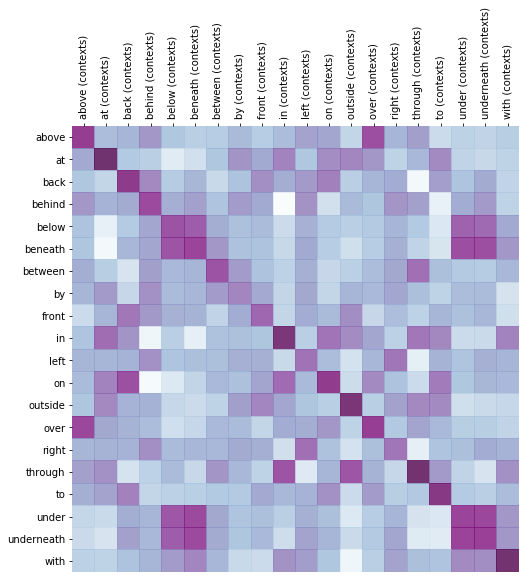

In [12]:
plot_matrix(data, contexts_a, words_a)

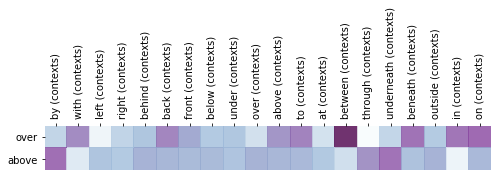

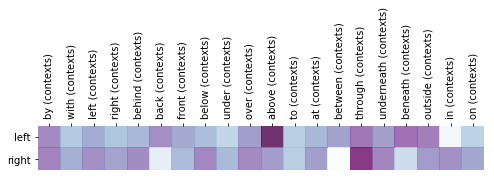

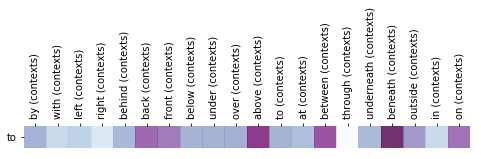

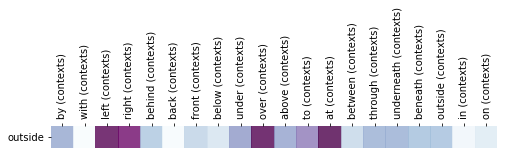

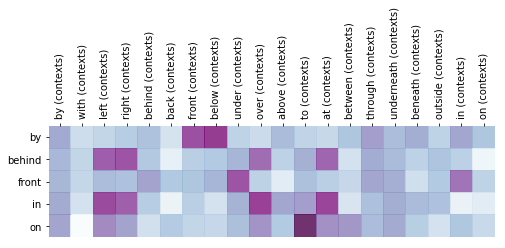

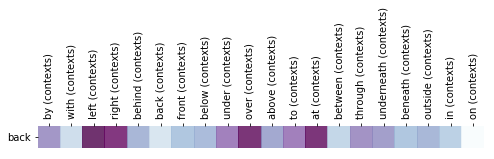

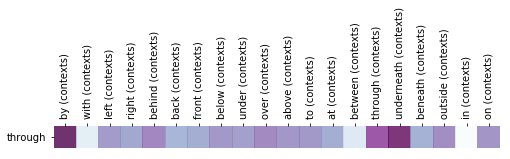

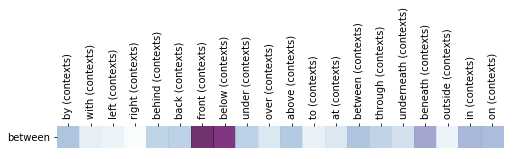

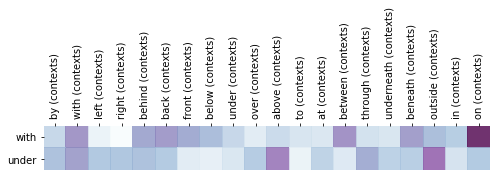

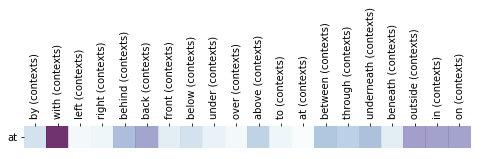

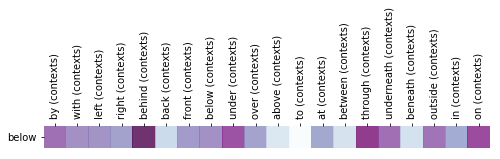

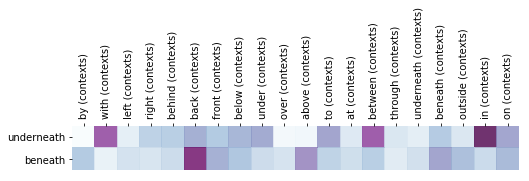

In [20]:
for i in range(k):
    words_a = words[clusters == i]
    plot_matrix(
        data[[np.where(words == w)[0][0] for w in words_a]][:,[np.where(contexts == w)[0][0] for w in contexts_a]],
        contexts_a,
        words_a
    )

In [12]:
simple_classification = [simple_classes[w] for w in words]

In [13]:
homogeneity_completeness_v_measure(simple_classification, clusters)

(0.58040387628993484, 0.85020587589869856, 0.68986358475629672)

In [14]:
for i in range(k):
    words_a = words[clusters == i]
    #print(i, words_a)
    words_a = [w for w in words_a if simple_classes_set[simple_classes[w]] in simple_classes_set2]
    print(i, [simple_classes_set[simple_classes[w]] for w in words_a])
    

0 ['with', 'without']
1 ['left', 'right']
2 ['by', 'behind', 'below', 'under', 'above', 'between', 'between', 'underneath', 'beneath']
3 ['back']
4 ['on']
5 ['over', 'to', 'at', 'in']
6 ['through']
7 ['left', 'left', 'right', 'back', 'back', 'front']
8 ['back', 'back', 'front', 'front']
9 ['away', 'apart', 'out', 'outside']


In [35]:
from time import time
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

X = embeddings_normal2
#y = np.array([simple_classes_set[simple_classes[w]] for w in words])
y = np.array(words)

X = embeddings_lm
y = np.array(spatial_lexicon)


# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        if simple_classes_set[simple_classes[y[i]]] not in simple_classes_set2:
            continue
        plt.text(X[i, 0], X[i, 1], y[i],
                 color=plt.cm.tab20(simple_classes_set2.index(simple_classes_set[simple_classes[y[i]]])/len(simple_classes_set2)),
                 fontdict={
                     #'weight': 'bold',
                     'size': 8
                 }
                )
        plt.scatter(X[i, 0], X[i, 1], #y[i],
                 color=plt.cm.tab20(simple_classes_set2.index(simple_classes_set[simple_classes[y[i]]])/len(simple_classes_set2)),
                )
    

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


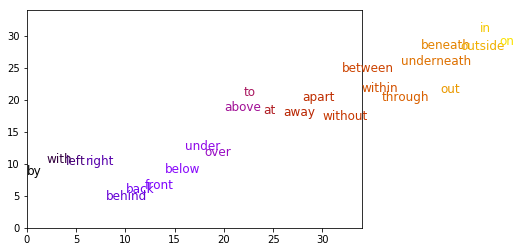

In [16]:
plt.figure()
ax = plt.subplot(111)
for i,w in enumerate(simple_classes_set2):
     plt.text(i*2, i+10*np.random.random(), str(w),
                 color=plt.cm.gnuplot(i/len(simple_classes_set2)),
                 fontdict={
                     #'weight': 'bold',
                     'size': 12
                 }
                )
ax.set_aspect('auto')
plt.xlim(xmax=len(words))
plt.ylim(ymax=len(words))
plt.show()

Computing t-SNE embedding


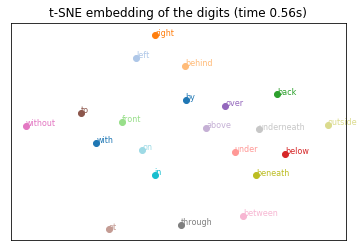

Computing Isomap embedding
Done.
Computing Totally Random Trees embedding


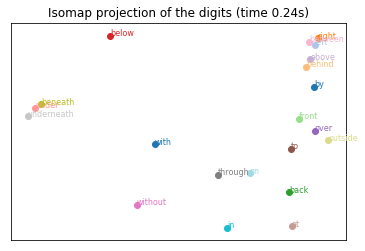

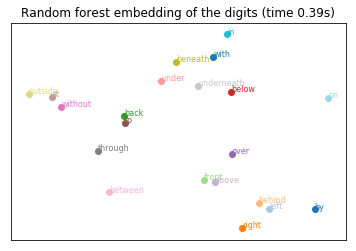

In [36]:
        
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

plt.show()

n_neighbors = 4

print("Computing Isomap embedding")
t0 = time()
X_iso = manifold.Isomap(n_neighbors, n_components=2).fit_transform(X)
print("Done.")
plot_embedding(X_iso,
               "Isomap projection of the digits (time %.2fs)" %
               (time() - t0))


print("Computing Totally Random Trees embedding")
hasher = ensemble.RandomTreesEmbedding(n_estimators=200, random_state=0,
                                       max_depth=5)
t0 = time()
X_transformed = hasher.fit_transform(X)
pca = decomposition.TruncatedSVD(n_components=2)
X_reduced = pca.fit_transform(X_transformed)

plot_embedding(X_reduced,
               "Random forest embedding of the digits (time %.2fs)" %
               (time() - t0))